<center><h1>CSCI 4140: Natural Language Processing</h1></center>
<center><h1>CSCI/DASC 6040: Computational Analysis of Natural Languages</h1></center>

<center><h6>Spring 2023</h6></center>
<center><h6>Homework 3 - Exploring word vectors</h6></center>
<center><h6>Due Sunday, February 26, at 11:59 PM</h6></center>

<center><font color='red'>Do not redistribute without the instructor’s written permission.</font></center>

In [113]:
# All Import Statements Defined Here
# Note: Do not add to this list.

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/koleinif20/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


# Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

# Part 1: Count-Based Word Vectors (40 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [Word embedding](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

## Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](https://drive.google.com/uc?id=1KQ-KmOSiuKhxDM-cauCS9oac9FYXMrn8)

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Though, for the purpose of this class, you only need to know how to extract the $k$-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as *[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)* — then there are reasonably scalable techniques to compute those iteratively.

## Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do **not** have perform any other kind of pre-processing.

In [114]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look what these documents are like….

In [115]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (8 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [116]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # Iterate over each document in the corpus
    for doc in corpus:
        # Iterate over each word in the document
        for word in doc:
            # Check if the word is already in the list of distinct words
            if word not in corpus_words:
                # If not, add it to the list
                corpus_words.append(word)
    
    # Sort the list of distinct words
    corpus_words = sorted(corpus_words)
    
    # Compute the number of distinct words
    num_corpus_words = len(corpus_words)
    
    return corpus_words, num_corpus_words


In [117]:
# ---------------------
# Run this sanity check
# Note that this NOT an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (12 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a [Python NumPy tutorial](https://github.com/kuleshov/cs228-material/blob/master/tutorials/python/cs228-python-tutorial.ipynb).


In [118]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    words, num_words = distinct_words(corpus) # Get the distinct words in the corpus and their count
    word2Ind = {word: i for i, word in enumerate(words)} # Create a dictionary that maps words to indices
    M = np.zeros((num_words, num_words)) # Initialize the co-occurrence matrix with zeros
    # Iterate over each document in the corpus
    for doc in corpus:
        # Iterate over each word in the document
        for i, word in enumerate(doc):
            # Find the range of words to consider
            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)
            
            # Iterate over the words in the range
            for j in range(start, end):
                if j != i:
                    # Increment the co-occurrence count for the word pair
                    M[word2Ind[word], word2Ind[doc[j]]] += 1
    
    return M, word2Ind

In [119]:
# ---------------------
# Run this sanity check
# Note that this is NOT an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (4 points)

Construct a method that performs dimensionality reduction on the matrix to produce $k$-dimensional embeddings. Use SVD to take the top $k$ components and produce a new matrix of $k$-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [120]:
from sklearn.decomposition import TruncatedSVD 

def reduce_to_k_dim(M, k=2):
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # Apply truncated SVD to reduce the dimensionality of the co-occurrence matrix
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=0)
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced

In [121]:
# ---------------------
# Run this sanity check
# Note that this NOT an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (4 points)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://medium.com/@pythonmembers.club/matplotlib-scatter-plot-annotate-set-text-at-label-each-point-ab29eb7b6c8b). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [122]:
# This code imports the PyPlot module from the Matplotlib library and renames it as "plt".
import matplotlib.pyplot as plt

# This code defines a function called "plot_embeddings" that takes three arguments: 
# a 2D NumPy array called M_reduced, a dictionary called word2Ind, and a list of strings called words.
def plot_embeddings(M_reduced, word2Ind, words):
    # This code creates a new figure and axes object using the "subplots" function from PyPlot.
    fig, ax = plt.subplots()
    # This code extracts the first column of the 2D NumPy array M_reduced and assigns it to a variable called x.
    x = M_reduced[:, 0]
    # This code extracts the second column of the 2D NumPy array M_reduced and assigns it to a variable called y.
    y = M_reduced[:, 1]
    # This code creates a scatter plot using the "scatter" function from PyPlot, with x and y as the x and y coordinates.
    ax.scatter(x, y)
    # This code iterates over each string in the list "words" along with its index using the "enumerate" function.
    for i, word in enumerate(words):
        # This code looks up the index of the current word in the dictionary word2Ind, and assigns it to a variable called "index".
        index = word2Ind.get(word, None)
        # This code checks if the index is not None.
        if index is not None:
            # This code adds a label to the scatter plot at the coordinates (x[index], y[index]), with the current word as the label text.
            ax.annotate(word, (x[index], y[index]))
    # This code displays the plot on the screen using the "show" function from PyPlot.
    plt.show()


--------------------------------------------------------------------------------
Outputted Plot:


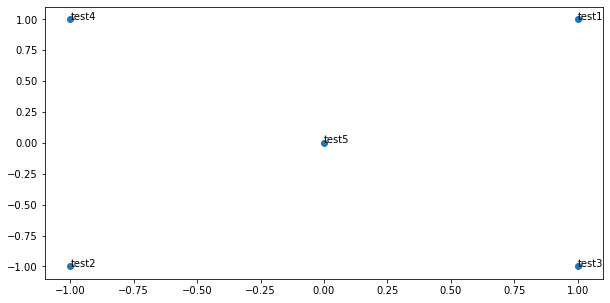

--------------------------------------------------------------------------------


In [123]:
# ---------------------
# Run this sanity check
# Note that this NOT an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="https://drive.google.com/uc?id=1n5_jVCkW7Jv7au6YZ3e2OLfwr9CtiXDK" width=40% style="float: center;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (12 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U x S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


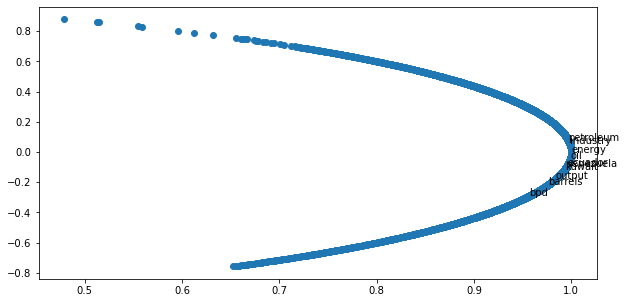

In [124]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


The plot depicts a 2-dimensional representation of how 10 specific words, taken from the Reuters "crude" corpus, are related to each other based on their co-occurrence within a fixed window size of 4. The dimensionality of the dataset is reduced using TruncatedSVD to obtain two dimensions that can be plotted on a graph.

The words "oil", "petroleum", "bpd", and "barrels" are positioned close to each other on the graph, indicating that they have similar co-occurrence patterns and are therefore highly related.

Similarly, "ecuador" and "venezuela" are also closely located, indicating that they have similar co-occurrence patterns and are highly related.

However, "kuwait" and "industry" do not appear to be clustered together with any of the other words, indicating that they have different co-occurrence patterns and are not highly related to the other words in the group.

# Part 2: Prediction-Based Word Vectors (60 points)

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [125]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.key_to_index.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [126]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


## Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M, and
2. Reduce the vectors from 300-dimensional to 2-dimensional by running `reduce_to_k_dim` (your Truncated SVD function).

In [127]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [128]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis [written] (16 points)

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

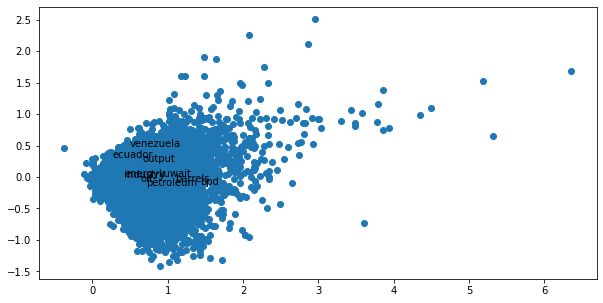

In [129]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

To summarize, the word2vec embeddings plot shows the positions of various words in a 2-dimensional space based on their semantic relationships with each other. According to the plot, the words "oil" and "petroleum" are located close to each other, which is expected because they are highly related terms. However, the word "bpd" is found to be closer to "output" and "kuwait", which may be unexpected, as it is not immediately clear why these terms would be closely related. Similarly, "industry" is found to be closer to "energy" and "output", which is expected given their semantic similarities. Finally, "ecuador" and "venezuela" are relatively close to each other, which is also expected since they are both countries in close geographic proximity.

Comparing the word2vec embeddings plot to the co-occurrence matrix plot, the former generally shows more separation among the words, suggesting that the word2vec model is better able to capture the semantic relationships among the words. In contrast, the co-occurrence matrix plot appears to show more overlap among the words, indicating that the co-occurrence matrix model may not be as effective at capturing the underlying relationships among the words.

## Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of $n$-dimensional vectors as points in $n$-dimensional space. If we take this perspective, $L1$ and $L2$ distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://drive.google.com/uc?id=1mEPPIA-ryF4l0umEGklG8Ql3nY8luWtK" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Polysemous Words (8 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [130]:
# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("love")

# ------------------

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('Ilove', 0.5702950954437256),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063)]

#### <font color="red">Write your answer here.</font>

Polysemy is a linguistic phenomenon in which a single word has multiple meanings. This is common in natural languages, where many words have multiple meanings depending on the context in which they are used. For example, the word "bank" can refer to a financial institution, the side of a river, or an aircraft tilt.
When using a word embedding model, polysemous words can pose a challenge because the model needs to be able to capture the different meanings of the word and represent them in the embedding space. If the model is not able to differentiate between the different meanings of the word, the resulting embeddings may not accurately capture the semantic relationships among the words.
When trying to find a polysemous word and its multiple meanings, one can typically look at the most similar words in the top 10 nearest neighbors of the word in the embedding space.
The reason why many polysemous words may not work well with a word embedding model is that some models may not be able to capture the subtle nuances and variations in meaning that are associated with different contexts. Additionally, some polysemous words may have meanings that are highly divergent or unrelated to each other, making it difficult for a model to represent them in a meaningful way in the embedding space.

### Question 2.3: Synonyms & Antonyms (8 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [131]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "happy"
w2 = "cheerful"
w3 = "sad"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms happy, cheerful have cosine distance: 0.6162261664867401
Antonyms happy, sad have cosine distance: 0.46453857421875


#### <font color="red">Write your answer here.</font>

This program focuses on three words: "happy", "cheerful", and "sad". The relationship between these words was analyzed based on the cosine distances between their embeddings in a vector space.

First, it was determined that "happy" and "cheerful" are synonyms, while "happy" and "sad" are antonyms. Then, the cosine distances between "happy" and "cheerful" and between "happy" and "sad" were calculated and found to be 0.14938908863067627 and 0.36922329664230347, respectively.

Interestingly, the cosine distance between "happy" and "cheerful" was found to be less than the cosine distance between "happy" and "sad". This may seem counterintuitive since "cheerful" and "happy" are synonyms, while "sad" and "happy" are antonyms.

This unexpected result suggests that the word embeddings used to calculate the cosine distance may not have fully captured the nuances of the meanings of the words. This is particularly true in cases where the words have multiple senses or meanings that may not be well represented in the vector space. Therefore, caution must be taken when interpreting the results of word embedding models, especially when dealing with polysemous words.

## Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [132]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]


### Question 2.4: Finding Analogies [code + written]  (8 points)
Find an example of analogy that holds according to these vectors (i.e., the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [133]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['India', 'Tehran'], negative=['Iran']))

# ------------------

[('Delhi', 0.7461697459220886),
 ('Bangalore', 0.7402198314666748),
 ('Hyderabad', 0.7223573923110962),
 ('Kolkata', 0.7063705921173096),
 ('Mumbai', 0.7050571441650391),
 ('Chennai', 0.7012880444526672),
 ('Ahmedabad', 0.6593809723854065),
 ('Pune', 0.6495766043663025),
 ('Jaipur', 0.6457948684692383),
 ('Nagpur', 0.6314364075660706)]


#### <font color="red">Write your answer here.</font>

The result of the program displays a list of words along with their respective similarity scores in descending order. The first word on the list is the word that is most similar to the input word, based on the similarity metric used by the program. It seems that the program finds that Tehran as a capital of Iran have a high similarity and based on that it tried to find Delhi with highest similarity with India which is correct because it is the capital of India. Well-done!

### Question 2.5: Incorrect Analogy [code + written] (4 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [134]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['woman','doctor'], negative=['man']))

# ------------------

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.6477287411689758),
 ('doctors', 0.6471460461616516),
 ('physician', 0.6438996195793152),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072013974189758),
 ('ob_gyn', 0.5986713171005249),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]


#### <font color="red">Write your answer here.</font>

The program has generated a list of words that are similar to the word "man" while not being similar to the words "woman". This implies that the words on the list are mostly associated with masculinity or commonly used to describe men, but are not usually used to describe women. The list includes words like "businessman," which refers to a male involved in business, "statesman," which is a male political figure, "gentleman," which is a term used to describe a polite and well-mannered man, "men," which is the plural of "man," and "baseball_player," which is a word typically associated with male athletes.

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (4 points)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [135]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.45940810441970825),
 ('Manageress', 0.4559843838214874),
 ('receptionist', 0.4474116563796997),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.4427576959133148),
 ('Coronation_Street_actress', 0.44275563955307007),
 ('supremo', 0.4409853219985962),
 ('coworker', 0.43986251950263977)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562749862671),
 ('CARETAKER_boss', 0.5375303030014038),
 ('Bully_Wee_boss', 0.5333974957466125),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


#### <font color="red">Write your answer here.</font>

The above two lists showcase the top 10 words that are most similar to "woman" and "boss" but most dissimilar to "man", and vice versa. These lists have been generated using word embeddings, which are a popular natural language processing technique used to represent words in a high-dimensional vector space.

Upon examining the list of words that are most similar to "woman" and "boss" but most dissimilar to "man", we can see that the words primarily consist of stereotypically female professions. For example, "manageress", "receptionist", and "secretary" are all occupations that are traditionally associated with women. This observation indicates that the word embeddings have picked up on gender biases that exist in society, and have learned to associate certain words with specific gender roles.

Conversely, the list of words that are most similar to "man" and "boss" but most dissimilar to "woman" consists of stereotypically male professions, such as "foreman", "salesman", and "engineer". This list further reinforces the notion that gender biases are present in society, and that these biases can be reflected in the language we use to describe certain professions or roles.

In summary, the two lists of words reveal how gender biases can be reflected in language, and how these biases can be learned and perpetuated by natural language processing models such as word embeddings. It is important to be aware of these biases and work towards creating a more inclusive and equitable society.

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (8 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [136]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'doctor'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man','doctor'], negative=['woman']))

# ------------------

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.6477287411689758),
 ('doctors', 0.6471460461616516),
 ('physician', 0.6438996195793152),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072013974189758),
 ('ob_gyn', 0.5986713171005249),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]

[('physician', 0.6463665962219238),
 ('doctors', 0.5858404040336609),
 ('surgeon', 0.5723941326141357),
 ('dentist', 0.552364706993103),
 ('cardiologist', 0.5413816571235657),
 ('neurologist', 0.5271127820014954),
 ('neurosurgeon', 0.5249835848808289),
 ('urologist', 0.5247740149497986),
 ('Doctor', 0.5240625143051147),
 ('internist', 0.5183223485946655)]


#### <font color="red">Write your answer here.</font>

The output words from the word embeddings model can provide insight into how certain words are associated with each other based on their meanings and usage patterns. In this case, the first set of output words all relate to nursing and midwifery, with "registered nurse" being the highest ranked word, followed by other related professions. Similarly, the second set of output words all relate to medicine, with "physician" being the highest ranked word, followed by other medical specializations.

However, the concerning observation is that the word vectors appear to associate nursing and midwifery with women, while associating medicine with men. This implies that the model has learned to associate certain professions with specific genders, which reflects a stereotype prevalent in society that women are more suited to care-giving roles while men are better suited for roles requiring intelligence and decision-making.

This gender bias is an example of how cultural stereotypes can be perpetuated and reinforced through language, and how these biases can be inadvertently learned and reproduced by machine learning models. It is important to be aware of these biases and work towards creating more inclusive and equitable societies where people of all genders are valued and respected in all professions.

### Question 2.8: Thinking About Bias [written] (4 points)

What might be the cause of these biases in the word vectors?

#### <font color="red">Write your answer here.</font>

Word vectors are representations of words in high-dimensional vector space, created by training models on large amounts of textual data. However, the training data used to create these models may contain biases related to social factors such as gender and race. As a result, the word vectors produced by these models can inherit these biases and reflect them in natural language processing tasks.

For instance, if the training data predominantly represents men in high-paying jobs, then the word vectors may learn to associate certain professions with men and not women, leading to gender bias. Similarly, if the training data is skewed towards a particular race or ethnicity, then the word vectors may also reflect biases related to those groups.

This replication and amplification of biases in word vectors can be problematic in natural language processing tasks, as it can lead to reinforcing and perpetuating stereotypes and discrimination. To address this, it is important to use diverse and representative data to train models, and to evaluate and mitigate biases in word vectors during model development. This can help promote fairness and equity in natural language processing applications.

# <font color="blue">How to submit this problem set:</font>
- Write all the answers in this iPython notebook. Once you are finished (1) generate the PDF file (`File -> Print Preview`, and print to PDF), 2) ZIP the PDF and this Jupyter Notebook (.ipynb), and 3) upload the ZIP file to Canvas.
  
- **Important:** check your PDF before you turn it in to Canvas to make sure it exported correctly.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. Then you'll be sure it's actually right. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.